# CLAM.peakcaller eCLIP Analysis
Date: June 26, 2018

Author: Zijun Zhang

## Introduction
This notebook is to document the debugging process for CLAM.peakcaller.

The problem is for certain genes/transcripts, the peak caller does not seem to call peaks even if visually the peak pattern looks convincing; i.e. the peak caller is not sensitive enough.

In this debugging notebook, I will use the eCLIP data of Esrp1 in mouse (in-house data from Russ), and more specifically look at gene Lsm14b.

The gene [Lsm14b](http://uswest.ensembl.org/Mus_musculus/Gene/Summary?db=core;g=ENSMUSG00000039108;r=2:180024987-180035465) is a strong candidate target of Esrp1, which harbors an Esrp1-repressed exon with Esrp1 motif upstream of the cassette exon. However, using CLAM.peakcaller on the individual CLIP-Input comparisons cannot identify signficant peaks.

First define the file paths and gene of interest:

In [2]:
from CLAM.peakcaller import *

# debugging variables
par_dir = "/u/home/f/frankwoe/nobackup/RussCarstens_Lab/eclip/CLAM_ENCODE_Snakemake/"
gene_of_interest = "ENSMUSG00000039108"  # Lsm14b

# peak-caller input variables; get this from `log.CLAM.txt`
#ip_bam_list = [par_dir+'projects/ESRP1_mm10_GI/clam/Combo_Urea_CLIP/unique.sorted.bam']
ip_bam_list = [par_dir+'projects/ESRP1_mm10_GI/clam/I925_FLAGCLIP/unique.sorted.bam']
gtf_fp = '/u/nobackup/yxing/NOBACKUP/frankwoe/mm10/gencode.vM13.annotation.gtf'
#con_bam_list = [par_dir+'projects/ESRP1_mm10_GI/clam/Combo_Urea_Input/unique.sorted.bam']
con_bam_list = [par_dir+'projects/ESRP1_mm10_GI/clam/I925_Input/unique.sorted.bam']
nthread = 1
# change this as not to overwrite the existing results
out_dir = par_dir+'projects/ESRP1_mm10_GI/clam/test'
binsize = 50
unique_only = True
unstranded = False
qval_cutoff = 0.5
fold_change = [0.01]

Now read in the GTF and open the bam files

In [3]:
if con_bam_list is not None:
    with_control = True
else:
    with_control = False
if len(ip_bam_list)==1 and not unique_only:
    logger.info('with only 1 bam file provided, i can only run --unique-only')
    unique_only=True

if nthread == 1:
    # file handlers only for single-thread
    bam_dict = make_bam_handler_dict(ip_bam_list, con_bam_list)

gene_annot = read_gtf(gtf_fp)

# print the gene of interest
gene = gene_annot[gene_of_interest]
print(gene)

# confirm there are no peaks called:
BED = call_gene_peak(bam_dict, gene, 
    unique_only=unique_only, with_control=with_control, 
    unstranded=unstranded, binsize=binsize, qval_cutoff=0.99, fold_change=fold_change)
print(BED)

['chr2', 180024987, 180035465, '+', 'ENSMUSG00000039108']
chr2	180031687	180031737	ENSMUSG00000039108-1	1000	+	1.23	2.537e-01	5.073e-01	.
chr2	180032487	180032537	ENSMUSG00000039108-2	1000	+	0.31	5.662e-01	7.549e-01	.
chr2	180034937	180034987	ENSMUSG00000039108-3	1000	+	1.10	1.243e-01	4.971e-01	.



## Examination of the eCLIP data: Lsm14b
OK, so for the I925 FLAGCLIP-Input comparison, the tracks look like below. Apparently there should be at least two significant peaks, listed as -1 and -3 above. However, the p-value is too large. Next I will find out why, by running code snippets from CLAM.peakcaller.

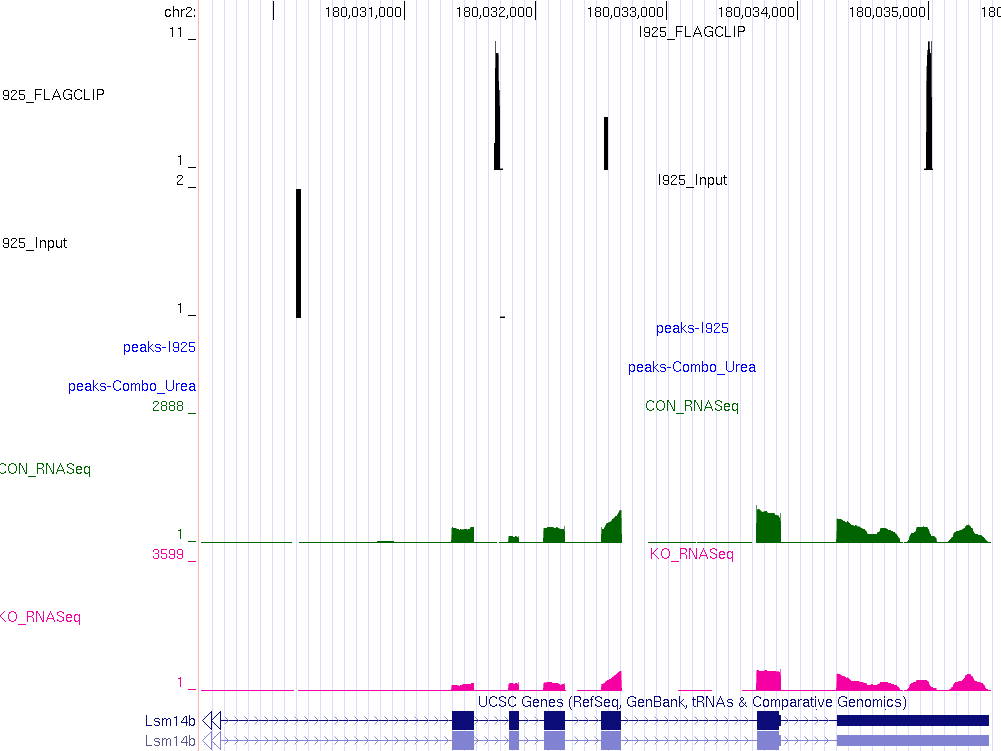

In [18]:
from IPython.display import Image 
Image(filename='notebook-image/image00.png')

In [5]:
# fetch the IP tag counts to gene regions
if unique_only:
    interval_ip = \
        count_gene_read_tags(bam_dict['ubam.ip'], gene, is_unique=True, unstranded=unstranded)
else:
    interval_ip = \
        count_gene_read_tags(bam_dict['ubam.ip'], gene, is_unique=True, unstranded=unstranded) + \
        count_gene_read_tags(bam_dict['mbam.ip'], gene, is_unique=False, unstranded=unstranded)
# fetch/construct the input tag counts
if with_control:
    ## count control tags if available
    if unique_only:
        interval_con = \
            count_gene_read_tags(bam_dict['ubam.con'], gene, is_unique=True, unstranded=unstranded)
    else:
        interval_con = \
            count_gene_read_tags(bam_dict['ubam.con'], gene, is_unique=True, unstranded=unstranded) + \
            count_gene_read_tags(bam_dict['mbam.con'], gene, is_unique=False, unstranded=unstranded)
else:
    ## otherwise, construct a uniform *fake* control
    interval_con = \
            np.ones((1, interval_ip.shape[1]))*np.sum(interval_ip)/interval_ip.shape[1]
    #interval_con = np.empty(interval_ip.shape)
    #for i in range(interval_ip.shape[0]):
    #	interval_con[i, ] = \
    #		np.ones((interval_ip.shape[1]))*np.sum(interval_ip[i,])/interval_ip.shape[1]

# bin tag counts into bins
intv_bin_ip = bin_interval_counts(interval_ip, binsize=binsize)
intv_bin_con = bin_interval_counts(interval_con, binsize=binsize)

# perform statistical test
signal_val, binscore_adj, binscore = test_bin_negbinom(intv_bin_ip, intv_bin_con, with_control=with_control)

# print the index for the three candidate bins
print("non-NA bins index and p-value")
print(np.where(~np.isnan(binscore)))
print(binscore[np.where(~np.isnan(binscore))])


non-NA bins index and p-value
(array([134, 150, 199, 200]),)
[ 0.25367323  0.56616053  0.12427     1.        ]


These p-values are identical to the output when I ran it through the whole gene.

Next I will examine the input count data and the optimization procedure of CLAM peak-caler Likelihood Ratio Test (LRT).

In [6]:
def _par_to_vec(par, data, is_constrained):
    if is_constrained:
        beta = par[0]
        mu_vec = par[1::]
        delta = 0
    else:
        beta, delta = par[0], par[1]
        mu_vec = par[2::]
    ip_counter = data['this_ip'].shape[0]
    con_counter = data['this_con'].shape[0]
    mu0 = np.asarray(mu_vec[0:con_counter])
    mu1 = np.asarray(mu_vec[con_counter::])
    lamb1_this = np.exp(mu1 + beta + delta)
    lamb1_others = np.exp(mu1)
    lamb0_this = np.exp(mu0 + beta)
    lamb0_others = np.exp(mu0)
    return (lamb1_this, lamb1_others, lamb0_this, lamb0_others)

def _negative_binom_logpmf(y, mu, alpha):
    y  = np.asarray(y)
    ll = np.empty(len(y))
    for i in range(len(y)):
        alpha_inv = 1.0/alpha[i]
        alpha_mu = float(alpha[i] * mu[i])
        ll[i] = y[i]* np.log(alpha_mu/(1+alpha_mu))- \
            alpha_inv*np.log(1+alpha_mu)
    return ll

def _neg_loglik_unconstrain(par, data):
    (l1, l2, l3, l4) = _par_to_vec(par, data, False)
    ll = np.sum( _negative_binom_logpmf(data['this_ip'], mu=l1, alpha=alpha_ip_vec))
    ll += np.sum( _negative_binom_logpmf(data['others_ip'], mu=l2, alpha=alpha_ip_vec))
    ll += np.sum( _negative_binom_logpmf(data['this_con'], mu=l3, alpha=alpha_con_vec))
    ll += np.sum( _negative_binom_logpmf(data['others_con'], mu=l4, alpha=alpha_con_vec))
    return -ll

def _neg_loglik_constrain(par, data):
    (l1, l2, l3, l4) = _par_to_vec(par, data, True)
    ll = np.sum(_negative_binom_logpmf(data['this_ip'], mu=l1, alpha=alpha_ip_vec)) + \
        np.sum(_negative_binom_logpmf(data['others_ip'], mu=l2, alpha=alpha_ip_vec)) + \
        np.sum(_negative_binom_logpmf(data['this_con'], mu=l3, alpha=alpha_con_vec)) + \
        np.sum(_negative_binom_logpmf(data['others_con'], mu=l4, alpha=alpha_con_vec))
    return -ll

intv_counter = intv_bin_ip.shape[1]
assert intv_counter == intv_bin_con.shape[1]
binscore = np.empty(intv_counter)
binsignal = np.empty(intv_counter, dtype='S50')
alpha_ip_vec = np.empty(intv_bin_ip.shape[0])
alpha_con_vec = np.empty(intv_bin_con.shape[0])
ip_sum = np.apply_along_axis(np.sum, 1, intv_bin_ip)
con_sum = np.apply_along_axis(np.sum, 1, intv_bin_con)
# compute the dispersion parameters
min_alpha = 0.001 ## small alpha reduces to Poisson
max_alpha = 0.01   ## large alpha costs loss of power
if with_control:
    for i in range(intv_bin_con.shape[0]):
        height = ztnb_em.collapse_data(np.floor(intv_bin_con[i,]))
        height[0] = 0
        try:
            ll, mu, alpha = ztnb_em.EM_estim_params(height, max_iter=10, verbose=False)
        except:   ## means truncated loglik=0, not enough data
            alpha = max_alpha
        alpha = max_alpha if alpha>max_alpha else alpha
        alpha = min_alpha if alpha<min_alpha else alpha
        alpha_con_vec[i] = alpha
    ## update alpha bounds based on control
    ## not until we have a better alpha estimate...  zijun 9.7.2017
    #max_alpha = np.min([ max_alpha, np.max(alpha_con_vec) ] )
    #min_alpha = np.max([ min_alpha, np.min(alpha_con_vec) ] )


for i in range(intv_bin_ip.shape[0]):
    height = ztnb_em.collapse_data(np.floor(intv_bin_ip[i,]))
    height[0] = 0
    if np.sum(height.values())>0:
        try:
            ll, mu, alpha = ztnb_em.EM_estim_params(height, max_iter=10, verbose=False)
        except:
            alpha = max_alpha
    else:
        alpha = max_alpha
    ## bound IP alpha by background max alpha
    ## because IP can be very sparse compared to control,
    ## as a result, alpha estimate can be quite off
    alpha = max_alpha if alpha>max_alpha else alpha
    alpha = min_alpha if alpha<min_alpha else alpha
    alpha_ip_vec[i] = alpha
# use the same dispersion if using *fake* control
if not with_control:
    alpha_con_vec = np.asarray(alpha_ip_vec)

pseudo_count = 1.
beta_bound = np.log(pseudo_count/np.min(np.concatenate([ip_sum, con_sum])))

print("estimated inflation param:")
print(alpha_ip_vec, alpha_con_vec)

estimated inflation param:
(array([ 0.01]), array([ 0.01]))


After initialized peak-calling related statistical functions, look at the first bin, i=134,

In [7]:
i=134
this_ip = intv_bin_ip[:, i]
others_ip = ip_sum - this_ip
this_con = intv_bin_con[:, i]
others_con = con_sum - this_con
data = {
        'this_ip':np.floor(this_ip),
        'others_ip':np.floor(others_ip),
        'this_con':np.floor(this_con),
        'others_con':np.floor(others_con)
    }
print(data)

{'others_con': array([ 5.]), 'this_con': array([ 1.]), 'others_ip': array([ 16.]), 'this_ip': array([ 11.])}


Looking at the data, it does seem very "insignificant". This can further be confirmed by a simple Fisher test:

In [16]:
%load_ext rpy2.ipython
%R d = matrix(c(5,1,16,11), nrow=2); print(d)
%R print(fisher.test(d, alternative='greater'))

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


     [,1] [,2]
[1,]    5   16
[2,]    1   11



	Fisher's Exact Test for Count Data

data:  d
p-value = 0.2695
alternative hypothesis: true odds ratio is greater than 1
95 percent confidence interval:
 0.404021      Inf
sample estimates:
odds ratio 
  3.327378 



The Fisher test p-value (0.27) is very close to CLAM.peakcaller reported LRT p-value (0.25). Hence we can confirm that the CLAM.peakcaller is working normally in terms of statistics given the observed data.

Now the problem becomes: do we expect to observe such a pattern under our model assumptions and our understanding of the experimental procedure(or, the data generating process in statistical terms)?

Not really. The eCLIP Size-Matched Input (SMInput) represents an unbiased (well, actually biased by crosslinking bias, which is a good thing in this case) coverage *sampling* of the RBP-RNA cross-linked regions, a procedure with UV crosslinking but without any antibody selection. Imagine the eCLIP SMInput sample as a blindly/randomly sampling of building blocks (RBPs) in a long bench (RNA transcript), while the IP sample is sampling blocks of a specific colour, say red blocks. 

Ideally, if there is a big pile of red blocks in IP sample at certain locations of the bench, that indicates there should be some blocks being blind-sampled in the SMInput as well. That is, if we see any enriched read coverage in IP sample, there should be at least some coverages in the SMInput sample. 

This was not the case in the I925 CLIP-Input comparison (see the track figure above). What could have happened to cause this? My guess is: **_dropout_**. Because eCLIP SMInput only uses 2% of the cross-linked RNA sample, some random regions are not sampled at all. This is detrimental to an enrichment-based peak-caller, like the current peak-caller version of [CLAM](https://github.com/zj-zhang/CLAM-BleedingEdge).

Next I will try to resolve this by integrating multiple replicates.

## Integrating multiple replicates

The idea of using multiple replicates is based on the assumption that the dropout pattern is random, hence doing multiple trials have a higher chance to see the full picture. If the dropout is not random, i.e. some regions are not tangible by SMInput strategy, this will not solve the issue.

First, I add all SMInput (n=4) to the model, and test that against I925 FLAGCLIP:

In [9]:
# bam list is a two-element list, 1st element is unique bam
# 2nd element is realigned multi-bam. Feed multiple files by
# separating them by comma. E.g.:
# ip_bam_list: ['IP_sam1,IP_sam2,..', 'IP.m_sam1,IP.m_sam2,..']
ip_bam_list = [par_dir+'projects/ESRP1_mm10_GI/clam/I925_FLAGCLIP/unique.sorted.bam']
con_bam_list = [
    ','.join([
        par_dir+'projects/ESRP1_mm10_GI/clam/I925_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I922_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I920_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/Combo_Urea_Input/unique.sorted.bam',
        ])
    ]

# open new file handlers in a dict
bam_dict = make_bam_handler_dict(ip_bam_list, con_bam_list)

# get read counts
if unique_only:
    interval_ip = \
        count_gene_read_tags(bam_dict['ubam.ip'], gene, is_unique=True, unstranded=unstranded)
else:
    interval_ip = \
        count_gene_read_tags(bam_dict['ubam.ip'], gene, is_unique=True, unstranded=unstranded) + \
        count_gene_read_tags(bam_dict['mbam.ip'], gene, is_unique=False, unstranded=unstranded)
# fetch/construct the input tag counts
if with_control:
    ## count control tags if available
    if unique_only:
        interval_con = \
            count_gene_read_tags(bam_dict['ubam.con'], gene, is_unique=True, unstranded=unstranded)
    else:
        interval_con = \
            count_gene_read_tags(bam_dict['ubam.con'], gene, is_unique=True, unstranded=unstranded) + \
            count_gene_read_tags(bam_dict['mbam.con'], gene, is_unique=False, unstranded=unstranded)
else:
    ## otherwise, construct a uniform *fake* control
    interval_con = \
            np.ones((1, interval_ip.shape[1]))*np.sum(interval_ip)/interval_ip.shape[1]
    #interval_con = np.empty(interval_ip.shape)
    #for i in range(interval_ip.shape[0]):
    #	interval_con[i, ] = \
    #		np.ones((interval_ip.shape[1]))*np.sum(interval_ip[i,])/interval_ip.shape[1]

# bin tag counts into bins
intv_bin_ip = bin_interval_counts(interval_ip, binsize=binsize)
intv_bin_con = bin_interval_counts(interval_con, binsize=binsize)

# re-estimate inflation alpha
intv_counter = intv_bin_ip.shape[1]
assert intv_counter == intv_bin_con.shape[1]
binscore = np.empty(intv_counter)
binsignal = np.empty(intv_counter, dtype='S50')
alpha_ip_vec = np.empty(intv_bin_ip.shape[0])
alpha_con_vec = np.empty(intv_bin_con.shape[0])
ip_sum = np.apply_along_axis(np.sum, 1, intv_bin_ip)
con_sum = np.apply_along_axis(np.sum, 1, intv_bin_con)
# compute the dispersion parameters
min_alpha = 0.001 ## small alpha reduces to Poisson
max_alpha = 0.01   ## large alpha costs loss of power
if with_control:
    for i in range(intv_bin_con.shape[0]):
        height = ztnb_em.collapse_data(np.floor(intv_bin_con[i,]))
        height[0] = 0
        try:
            ll, mu, alpha = ztnb_em.EM_estim_params(height, max_iter=10, verbose=False)
        except:   ## means truncated loglik=0, not enough data
            alpha = max_alpha
        alpha = max_alpha if alpha>max_alpha else alpha
        alpha = min_alpha if alpha<min_alpha else alpha
        alpha_con_vec[i] = alpha
    ## update alpha bounds based on control
    ## not until we have a better alpha estimate...  zijun 9.7.2017
    #max_alpha = np.min([ max_alpha, np.max(alpha_con_vec) ] )
    #min_alpha = np.max([ min_alpha, np.min(alpha_con_vec) ] )


for i in range(intv_bin_ip.shape[0]):
    height = ztnb_em.collapse_data(np.floor(intv_bin_ip[i,]))
    height[0] = 0
    if np.sum(height.values())>0:
        try:
            ll, mu, alpha = ztnb_em.EM_estim_params(height, max_iter=10, verbose=False)
        except:
            alpha = max_alpha
    else:
        alpha = max_alpha
    ## bound IP alpha by background max alpha
    ## because IP can be very sparse compared to control,
    ## as a result, alpha estimate can be quite off
    alpha = max_alpha if alpha>max_alpha else alpha
    alpha = min_alpha if alpha<min_alpha else alpha
    alpha_ip_vec[i] = alpha
# use the same dispersion if using *fake* control
if not with_control:
    alpha_con_vec = np.asarray(alpha_ip_vec)

pseudo_count = 1.
beta_bound = np.log(pseudo_count/np.min(np.concatenate([ip_sum, con_sum])))

print('beta_bound', beta_bound)
print("estimated inflation param:")
print(alpha_ip_vec, alpha_con_vec)

('beta_bound', -1.791759469228055)
estimated inflation param:
(array([ 0.01]), array([ 0.01      ,  0.00862939,  0.01      ,  0.01      ]))


In [10]:
i=134
this_ip = intv_bin_ip[:, i]
others_ip = ip_sum - this_ip
this_con = intv_bin_con[:, i]
others_con = con_sum - this_con
data = {
        'this_ip':np.floor(this_ip),
        'others_ip':np.floor(others_ip),
        'this_con':np.floor(this_con),
        'others_con':np.floor(others_con)
    }
print(data)

## constrained likelihood
res_constrain = optimize.minimize(
        x0=np.ones(1+this_ip.shape[0]+this_con.shape[0]), # beta + mu_vec 
        fun=_neg_loglik_constrain,
        args=(data),
        method='l-bfgs-b',
        bounds = [(beta_bound, abs(beta_bound) )]+[(0.1,10)]*(this_ip.shape[0]+this_con.shape[0]),
        options={'disp':False}
    )
## unconstrained likelihood
res_unconstrain = optimize.minimize(
        x0=np.ones(2+this_ip.shape[0]+this_con.shape[0]), # beta + delta + mu_vec
        fun=_neg_loglik_unconstrain,
        args=(data),
        method='l-bfgs-b',
        bounds = [(beta_bound, abs(beta_bound))] + [(-100,100)] + [(0.1,10)]*(this_ip.shape[0]+this_con.shape[0]),
        options={'disp':False}
    )

delta_mle = res_unconstrain.x[1]
pval = 1 - chi2.cdf(2*(res_constrain.fun - res_unconstrain.fun), 1)
print('delta_mle', delta_mle)
print('pvalue:', pval)

{'others_con': array([  5.,  11.,   8.,  10.]), 'this_con': array([ 1.,  0.,  0.,  0.]), 'others_ip': array([ 16.]), 'this_ip': array([ 11.])}
('delta_mle', 1.4170600665189506)
('pvalue:', 0.0022429316374342756)


There we go! Now the p-value is significant. See the full results for this gene. (I also managed to fix a dimenstion-unmatched bug in the likelihood optimization function..)

In [11]:
# run statistical model with multiple SMInput
BED = call_gene_peak(bam_dict, gene, 
    unique_only=unique_only, with_control=with_control, 
    unstranded=unstranded, binsize=binsize, qval_cutoff=0.99, fold_change=fold_change)
print(BED)

chr2	180031687	180031737	ENSMUSG00000039108-1	1000	+	1.42	2.243e-03	8.972e-03	.
chr2	180032487	180032537	ENSMUSG00000039108-2	1000	+	0.31	5.585e-01	7.447e-01	.
chr2	180034937	180034987	ENSMUSG00000039108-3	1000	+	1.10	1.688e-02	3.377e-02	.



## Integrating multiple IP and Input samples

We can also incorporate all CLIP IP samples, to make the peak-calling statistically more powerful (i.e. more significant peak p-values) and reduce bogus peaks.

In [17]:
ip_bam_list = [
    ','.join([
        par_dir+'projects/ESRP1_mm10_GI/clam/I917_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I920_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I921_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I922_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I923_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I924_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I925_FLAGCLIP/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/Combo_Urea_CLIP/unique.sorted.bam',
        ])
    ]
con_bam_list = [
    ','.join([
        par_dir+'projects/ESRP1_mm10_GI/clam/I925_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I922_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/I920_Input/unique.sorted.bam',
        par_dir+'projects/ESRP1_mm10_GI/clam/Combo_Urea_Input/unique.sorted.bam',
        ])
    ]

# open new file handlers in a dict
bam_dict = make_bam_handler_dict(ip_bam_list, con_bam_list)

# re-run analysis; replicate model
BED = call_gene_peak(bam_dict, gene, 
    unique_only=unique_only, with_control=with_control, 
    unstranded=unstranded, binsize=binsize, qval_cutoff=0.05, fold_change=fold_change,
    min_clip_cov=4, pool=False)
print(">>> replicate model")
print(BED)
print('')

# re-run analysis; pool model
BED = call_gene_peak(bam_dict, gene, 
    unique_only=unique_only, with_control=with_control, 
    unstranded=unstranded, binsize=binsize, qval_cutoff=0.05, fold_change=fold_change,
    min_clip_cov=4, pool=True)
print(">>> pooling model")
print(BED)
print('')

>>> replicate model
chr2	180031687	180031737	ENSMUSG00000039108-1	1000	+	1.48	3.536e-05	4.597e-04	.


>>> pooling model
chr2	180031687	180031737	ENSMUSG00000039108-1	1000	+	3.26	4.089e-06	5.725e-05	.
chr2	180034937	180034987	ENSMUSG00000039108-2	1000	+	1.92	5.099e-03	2.380e-02	.
chr2	180034987	180035037	ENSMUSG00000039108-3	1000	+	2.03	2.881e-03	2.017e-02	.




## Conclusion

Through this notebook, I have learned:
- confirmed the expected behaviour for CLAM.peakcaller;
- identified potential drop-out issue with eCLIP SMInput;
- use multiple replicates to partially resolve the drop-out issue;
- CLAM replicate model is more conservative than pooling when replicates are heterogeneous (large within group variance), a behaviour similar to other replicate models (e.g. [DARTS](https://github.com/zj-zhang/DARTS-BleedingEdge) replicate model);
- update CLAM to v1.1.3, see [here](https://github.com/zj-zhang/CLAM-BleedingEdge).

